In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11490712775420048592
]


In [2]:
import pickle

with open('standarized_sn.data', 'rb') as filehandle:
    # read the data as binary data stream
    standarized_sn = pickle.load(filehandle)

with open('flux_sn.data', 'rb') as filehandle:
    # read the data as binary data stream
    flux_sn = pickle.load(filehandle)

with open('flux_host.data', 'rb') as filehandle:
    # read the data as binary data stream
    flux_host = pickle.load(filehandle)

with open('standarized_hosts.data', 'rb') as filehandle:
    # read the data as binary data stream
    standarized_host = pickle.load(filehandle)

with open('wave_sn.data', 'rb') as filehandle:
    # read the data as binary data stream
    wave_em_sn = pickle.load(filehandle)

with open('wave_host.data', 'rb') as filehandle:
    # read the data as binary data stream
    wave_em_host = pickle.load(filehandle)

with open('wave_obs.data', 'rb') as filehandle:
    # read the data as binary data stream
    wave_obs = pickle.load(filehandle)

In [3]:
with open('standarized_em_host.data', 'rb') as filehandle:
    # read the data as binary data stream
    standarized_em_host = pickle.load(filehandle)
with open('standarized_em_sn.data', 'rb') as filehandle:
    # read the data as binary data stream
    standarized_em_sn = pickle.load(filehandle)

In [4]:
from numpy.random import seed
seed(1)
import pickle
import numpy as np
from datetime import datetime
import os

import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.layers import (Input, Dense, Activation, ZeroPadding1D, 
BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout,Add, LSTM,Embedding)
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

from tensorflow.keras import utils


#from desispec.interpolation import resample_flux

from tensorflow.keras import backend as K



plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
#plt.rcParamsDefault['axes.prop_cycle']
plt.rcParams['font.size'] = 16
plt.rcParams['axes.grid'] = True
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rc('grid',alpha=0.3,linestyle='--')

In [5]:
auc = tf.keras.metrics.AUC(curve='PR')
precision = tf.keras.metrics.Precision()

In [6]:
def network_aucprecision(input_shape, learning_rate=0.0005, reg=0.0032, dropout=0.7436, seed=None):
    """ 
    Args:
    input_shape -- shape of the input spectra
    regularization_strength -- regularization factor
    dropout -- dropout rate
    seed -- seed of initializer
    Returns:
    model -- a Model() instance in Keras
    """

    X_input = Input(input_shape, name='Input_Spec')

    with K.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    with K.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
    with K.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    with K.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

        
    # FLATTEN -> FULLYCONNECTED
    with K.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    with K.name_scope('Output_Layer'):
        X = Dense(1, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy',
                  metrics=[auc,precision])
    return model

In [7]:
def roc_pr_cm_histAUCPrecision(X,y):
    # Splitting the data 
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.25)
    """Trying from the blog"""
    from keras.models import Sequential
    from keras.layers import Dense
    # Classifier
    from keras.wrappers.scikit_learn import KerasClassifier
    keras_model = network_aucprecision((400,1))

    keras_model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=1)

    from sklearn.metrics import roc_curve
    y_pred_keras = keras_model.predict(X_test).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

    # Area under the curve
    from sklearn.metrics import auc
    auc_keras = auc(fpr_keras, tpr_keras)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    ############
    import random
    import pylab as pl
    import numpy as np
    from sklearn import svm, datasets
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import auc

    """# The source code uses decision_function
    but that is only applicable to sequential class and not the model class that our classifer uses.
    Check here for more reference: https://stats.stackexchange.com/questions/329857/what-is-the-difference-between-decision-function-predict-proba-and-predict-fun"""
    y_score = keras_model.predict(X_test).ravel() 


    # Average precision score
    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score(y_test, y_score)

    print('Average precision-recall score: {0:0.2f}'.format(average_precision))

    #https://scikit-plot.readthedocs.io/en/stable/Quickstart.html
    #Used Professor's Benzvi's code for PR curve

    from sklearn.metrics import precision_recall_curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_keras)
    plt.figure()
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision Recall Curve with average precision of {0:0.2f}'.format(average_precision))
    
    ########
    
    from sklearn.metrics import confusion_matrix

    y_pred = y_pred_keras

    def plotConfusionMatrix(y_true, y_pred, classes=["Hosts", "Type IAs", "Type IIPs"], cmap=plt.cm.gray, title="Normalized Confusion Matrix"):
        from sklearn.metrics import accuracy_score
        from sklearn.metrics import confusion_matrix
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        #print(cm)
        print("Accuracy: ", accuracy_score(y_true, y_pred))
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
        # create text annotations
        fmt = '.3f'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] < thresh else "black")
        fig.tight_layout()
        plt.ylim([1.5, -.5])

        plt.show()
        return ax

    for i in range(len(y_pred)):
        y_pred[i]=round(y_pred[i])

    plotConfusionMatrix(y_true=y_test, y_pred=y_pred, title="Normalized Conf. Matrix")
    
    ###################
    history = keras_model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), shuffle=True)
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    a = np.mean(history.history['precision'])
    v = np.mean(history.history['val_precision'])
    plt.title('mean_precision = {0:0.3f}, mean_val_precision = {1:0.3f}'.format(a,v))
    plt.ylabel('precision')
    plt.ylim([0.5,1])
    plt.xlabel('epoch')
    plt.legend(['precision', 'val_precision'], loc='best')
    plt.show()
    
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    a = np.mean(history.history['auc'])
    v = np.mean(history.history['val_auc'])
    plt.title('mean_auc = {0:0.3f}, mean_val_auc = {1:0.3f}'.format(a,v))
    plt.ylabel('AUC')
    plt.ylim([0.5,1])
    plt.xlabel('epoch')
    plt.legend(['auc', 'val_auc'], loc='best')
    plt.show()

In [8]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
X = np.concatenate([standarized_sn,standarized_host]).reshape(-1,400,1)
y = np.concatenate([np.zeros(standarized_sn.shape[0]),np.ones(standarized_host.shape[0])])

Using TensorFlow backend.
W0702 16:49:01.738465 47780620644032 deprecation.py:506] From /software/tensorflow/2.0.0a/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1296: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/30
11184/11184 [==============================] - 11s 980us/sample - loss: 1.6923 - auc: 0.7365 - precision: 0.6910
Epoch 2/30
11184/11184 [==============================] - 10s 905us/sample - loss: 1.1448 - auc: 0.8177 - precision: 0.7244
Epoch 3/30
11184/11184 [==============================] - 10s 908us/sample - loss: 0.9274 - auc: 0.8573 - precision: 0.7515
Epoch 4/30
11184/11184 [==============================] - 10s 916us/sample - loss: 0.7999 - auc: 0.8779 - precision: 0.7786
Epoch 5/30
11184/11184 [==============================] - 10s 902us/sample - loss: 0.7077 - auc: 0.8993 - precision: 0.8041
Epoch 6/30
11184/11184 [==============================] - 10s 908us/sample - loss: 0.6331 - auc: 0.9182 - precision: 0.8246
Epoch 7/30
11184/11184 [==============================] - 10s 906us/sample - loss: 0.5769 - auc: 0.9310 - precision: 0.8462
Epoch 8/30
11184/11184 [==============================] - 10s 903us/sample - loss: 0.5232 - auc: 0.9452 - precision: 0.8633
Epoch 9/

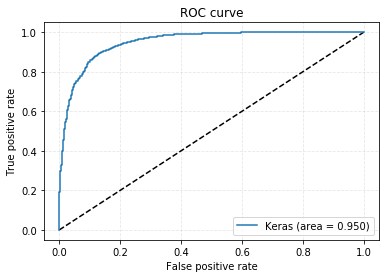

Average precision-recall score: 0.97
Normalized confusion matrix
Accuracy:  0.8798605524269241


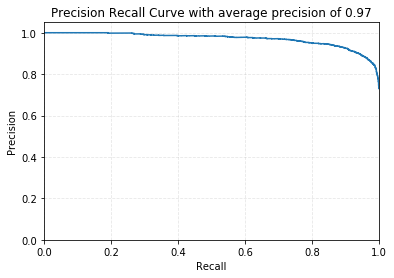

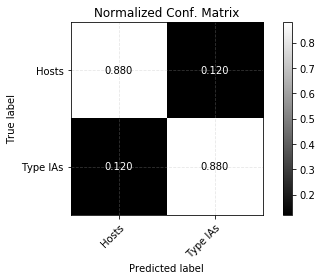

Train on 11184 samples, validate on 3729 samples
Epoch 1/30
11184/11184 [==============================] - 11s 1ms/sample - loss: 0.2669 - auc: 0.9894 - precision: 0.9429 - val_loss: 0.5384 - val_auc: 0.9343 - val_precision: 0.8140
Epoch 2/30
11184/11184 [==============================] - 11s 1ms/sample - loss: 0.2634 - auc: 0.9897 - precision: 0.9485 - val_loss: 0.4929 - val_auc: 0.9598 - val_precision: 0.9333
Epoch 3/30
11184/11184 [==============================] - 11s 1ms/sample - loss: 0.2582 - auc: 0.9907 - precision: 0.9469 - val_loss: 0.3866 - val_auc: 0.9704 - val_precision: 0.9303
Epoch 4/30
11184/11184 [==============================] - 11s 1ms/sample - loss: 0.2487 - auc: 0.9918 - precision: 0.9522 - val_loss: 0.3901 - val_auc: 0.9679 - val_precision: 0.8851
Epoch 5/30
11184/11184 [==============================] - 11s 1ms/sample - loss: 0.2465 - auc: 0.9923 - precision: 0.9513 - val_loss: 0.6379 - val_auc: 0.9446 - val_precision: 0.8081
Epoch 6/30
11184/11184 [============

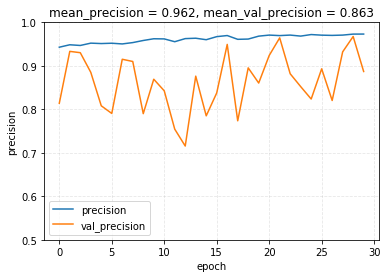

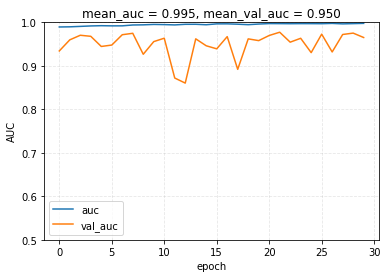

In [9]:
roc_pr_cm_histAUCPrecision(X,y)

In [10]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
X_em = np.concatenate([standarized_em_sn,standarized_em_host]).reshape(-1,400,1)
y_em = np.concatenate([np.zeros(standarized_em_sn.shape[0]),np.ones(standarized_em_host.shape[0])])

Epoch 1/30
11184/11184 [==============================] - 11s 970us/sample - loss: 1.8858 - auc: 0.7141 - precision: 0.6797
Epoch 2/30
11184/11184 [==============================] - 10s 903us/sample - loss: 1.3379 - auc: 0.7708 - precision: 0.7002
Epoch 3/30
11184/11184 [==============================] - 10s 928us/sample - loss: 1.0802 - auc: 0.8079 - precision: 0.7145
Epoch 4/30
11184/11184 [==============================] - 10s 916us/sample - loss: 0.9182 - auc: 0.8340 - precision: 0.7361
Epoch 5/30
11184/11184 [==============================] - 10s 902us/sample - loss: 0.8148 - auc: 0.8525 - precision: 0.7534
Epoch 6/30
11184/11184 [==============================] - 10s 905us/sample - loss: 0.7371 - auc: 0.8714 - precision: 0.7619
Epoch 7/30
11184/11184 [==============================] - 10s 909us/sample - loss: 0.6853 - auc: 0.8807 - precision: 0.7776
Epoch 8/30
11184/11184 [==============================] - 10s 904us/sample - loss: 0.6331 - auc: 0.8982 - precision: 0.7938
Epoch 9/

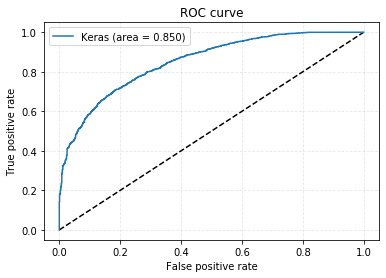

Average precision-recall score: 0.92
Normalized confusion matrix
Accuracy:  0.7275408956824886


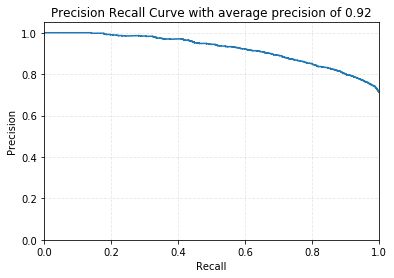

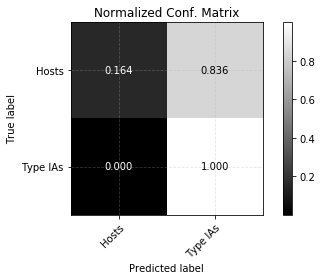

Train on 11184 samples, validate on 3729 samples
Epoch 1/30
11184/11184 [==============================] - 12s 1ms/sample - loss: 0.3409 - auc: 0.9795 - precision: 0.9053 - val_loss: 0.4739 - val_auc: 0.9575 - val_precision: 0.8234
Epoch 2/30
11184/11184 [==============================] - 11s 1ms/sample - loss: 0.3348 - auc: 0.9801 - precision: 0.9102 - val_loss: 0.5075 - val_auc: 0.9581 - val_precision: 0.9133
Epoch 3/30
11184/11184 [==============================] - 11s 1ms/sample - loss: 0.3353 - auc: 0.9810 - precision: 0.9093 - val_loss: 0.4091 - val_auc: 0.9702 - val_precision: 0.9281
Epoch 4/30
11184/11184 [==============================] - 11s 1ms/sample - loss: 0.3288 - auc: 0.9812 - precision: 0.9140 - val_loss: 0.5381 - val_auc: 0.9527 - val_precision: 0.9351
Epoch 5/30
11184/11184 [==============================] - 11s 1ms/sample - loss: 0.3253 - auc: 0.9813 - precision: 0.9152 - val_loss: 0.3520 - val_auc: 0.9809 - val_precision: 0.9295
Epoch 6/30
11184/11184 [============

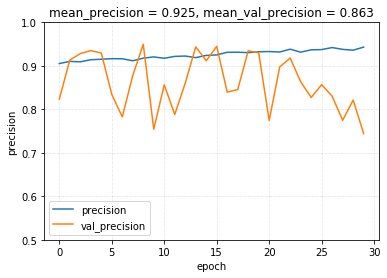

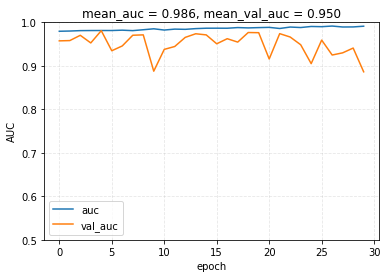

In [11]:
roc_pr_cm_histAUCPrecision(X=X_em,y=y_em)

# INDIVIDUAL ONES

In [14]:
model2=network_aucprecision((400,1))

In [15]:
permute = np.random.permutation(y.shape[0])
l = len(X)
hist = model2.fit(X[permute][:l],y[permute][:l],batch_size=64,epochs=30,validation_split=0.25,shuffle=True)

Train on 11184 samples, validate on 3729 samples
Epoch 1/30
11184/11184 [==============================] - 13s 1ms/sample - loss: 1.7117 - auc: 0.7508 - precision: 0.6967 - val_loss: 1.4086 - val_auc: 0.8499 - val_precision: 0.6645
Epoch 2/30
11184/11184 [==============================] - 11s 1ms/sample - loss: 1.1749 - auc: 0.8292 - precision: 0.7365 - val_loss: 1.1216 - val_auc: 0.8478 - val_precision: 0.6750
Epoch 3/30
11184/11184 [==============================] - 11s 1ms/sample - loss: 0.9424 - auc: 0.8699 - precision: 0.7686 - val_loss: 0.9201 - val_auc: 0.8948 - val_precision: 0.7619
Epoch 4/30
11184/11184 [==============================] - 11s 1ms/sample - loss: 0.8092 - auc: 0.8860 - precision: 0.7935 - val_loss: 0.7970 - val_auc: 0.8850 - val_precision: 0.7491
Epoch 5/30
11184/11184 [==============================] - 11s 1ms/sample - loss: 0.7154 - auc: 0.9043 - precision: 0.8112 - val_loss: 0.7168 - val_auc: 0.8995 - val_precision: 0.7696
Epoch 6/30
11184/11184 [============

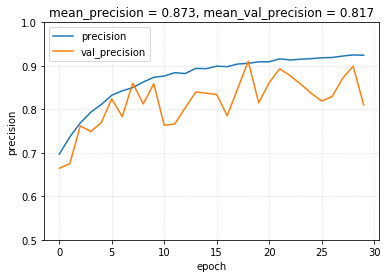

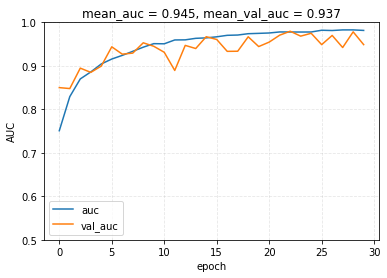

In [16]:
plt.plot(hist.history['precision'])
plt.plot(hist.history['val_precision'])
a = np.mean(hist.history['precision'])
v = np.mean(hist.history['val_precision'])
plt.title('mean_precision = {0:0.3f}, mean_val_precision = {1:0.3f}'.format(a,v))
plt.ylabel('precision')
plt.ylim([0.5,1])
plt.xlabel('epoch')
plt.legend(['precision', 'val_precision'], loc='best')
plt.show()
plt.tight_layout()

plt.plot(hist.history['auc'])
plt.plot(hist.history['val_auc'])
a = np.mean(hist.history['auc'])
v = np.mean(hist.history['val_auc'])
plt.title('mean_auc = {0:0.3f}, mean_val_auc = {1:0.3f}'.format(a,v))
plt.ylabel('AUC')
plt.ylim([0.5,1])
plt.xlabel('epoch')
plt.legend(['auc', 'val_auc'], loc='best')
plt.show()

In [ ]:
permute = np.random.permutation(y_em.shape[0])
l = len(X_em)
hist1 = model2.fit(X_em[permute][:l],y_em[permute][:l],batch_size=64,epochs=30,
                  validation_split=0.25,shuffle=True)

In [ ]:
plt.plot(hist1.history['precision'])
plt.plot(hist1.history['val_precision'])
a = np.mean(hist1.history['precision'])
v = np.mean(hist1.history['val_precision'])
plt.title('mean_precision = {0:0.3f}, mean_val_precision = {1:0.3f}'.format(a,v))
plt.ylabel('precision')
plt.ylim([0.5,1])
plt.xlabel('epoch')
plt.legend(['precision', 'val_precision'], loc='best')
plt.show()

plt.plot(hist1.history['auc'])
plt.plot(hist1.history['val_auc'])
a = np.mean(hist1.history['auc'])
v = np.mean(hist1.history['val_auc'])
plt.title('mean_auc = {0:0.3f}, mean_val_auc = {1:0.3f}'.format(a,v))
plt.ylabel('AUC')
plt.ylim([0.5,1])
plt.xlabel('epoch')
plt.legend(['auc', 'val_auc'], loc='best')
plt.show()